<a href="https://colab.research.google.com/github/ashaduzzaman-sarker/Image-Classification/blob/main/Image_classification_with_Involutional_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification with Involutional neural networks

**Author:**[Ashaduzzaman Sarker](https://www.linkedin.com/in/ashaduzzaman-sarker-piash/)
<br>
**Date created:** 23/06/24
<br>
**Reference:**
- [Involution: Inverting the Inherence of Convolution for Visual Recognition](
https://doi.org/10.48550/arXiv.2103.06255
)
- [Keras](https://keras.io/examples/vision/involution/)


## Introduction

- **Convolution** has been fundamental to modern neural networks in computer vision.
  - It is **spatial-agnostic** and **channel-specific**.
  - It struggles to adapt to different spatial patterns and capture long-range spatial interactions.

- To address these issues, **Li et al.** propose the **"involution kernel"** in their work "[Involution: Inverting the Inherence of Convolution for Visual Recognition.](
https://doi.org/10.48550/arXiv.2103.06255
)"
  - The involution kernel is **location-specific** and **channel-agnostic**.
  - Due to its location-specific nature, the involution operation aligns with the design principles of **self-attention**.

- The paper:
  - Describes the **involution kernel**.
  - Compares **two image classification models**: one using convolution and the other using involution.
  - Draws parallels between the **involution kernel** and **self-attention layers**.

## Imports

In [1]:
!pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 26.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [2]:
import os

os.environ['KERAS_BACKGROUND'] = 'tensorflow'

import tensorflow as tf
import keras
import matplotlib.pyplot as plt

tf.random.set_seed(42)

## **Convolution**

- **Convolution** : remains the mainstay of deep neural networks for computer vision. To understand involution, it is necessary to talk about the convolution operation.

- **Input Tensor (X)**: Dimensions H, W, and C_in.
- **Convolution Kernels**: A collection of C_out kernels, each of shape K, K, C_in.
- **Output Tensor (Y)**: Dimensions H, W, and C_out, obtained through a multiply-add operation between the input tensor and the kernels.

- **Example**: In the diagram below, C_out = 3, resulting in an output tensor of shape H, W, and 3.

- **Location-Agnostic**: The convolution kernel does not depend on the spatial position of the input tensor.
- **Channel-Specific**: Each channel in the output tensor is based on a specific convolution filter.

![](https://i.imgur.com/MSKLsm5.png)

## Involution

- The idea is to have an operation that is both **location-specific** and **channel-agnostic**.
- **Challenge**: Implementing these properties is difficult with a fixed number of involution kernels for each spatial position, as it cannot process variable-resolution input tensors.

**Solution**:
- **Generate each kernel conditioned on specific spatial positions**.
- This method allows processing of variable-resolution input tensors with ease.

**Diagram**:
- The diagram below provides an intuition on this **kernel generation method**.

![](https://i.imgur.com/jtrGGQg.png)

## Building the Involution layer

In [3]:
class Involution(keras.layers.Layer):
    def __init__(
        self, channel, group_number, kernel_size, stride, reduction_ratio, name
    ):
        super().__init__(name=name)

        # Initialize the parameters
        self.channel = channel
        self.group_number = group_number
        self.kernel_size = kernel_size
        self.stride = stride
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        # Get the shape of the input
        (_, height, width, num_channels) = input_shape

        # Scale the height and width with respect to the strides
        height = height // self.stride
        width = width // self.stride

        # Define a layer that average pools the input tensor if stride is more than 1.
        self.stride_layer = (
            keras.layers.AveragePooling2D(
                pool_size=self.stride, strides=self.stride, padding="same"
            )
            if self.stride > 1
            else tf.identity
        )
        # Define the kernel generation layer
        self.kernel_gen = keras.Sequential(
            [
                keras.layers.Conv2D(
                    filters=self.channel // self.reduction_ratio, kernel_size=1
                ),
                keras.layers.BatchNormalization(),
                keras.layers.ReLU(),
                keras.layers.Conv2D(
                    filters=self.kernel_size * self.kernel_size * self.group_number,
                    kernel_size=1,
                ),
            ]
        )
        # Define reshape layers
        self.kernel_reshape = keras.layers.Reshape(
            target_shape=(
                height,
                width,
                self.kernel_size * self.kernel_size,
                1,
                self.group_number,
            )
        )
        self.input_patches_reshape = keras.layers.Reshape(
            target_shape=(
                height,
                width,
                self.kernel_size * self.kernel_size,
                num_channels // self.group_number,
                self.group_number,
            )
        )
        self.output_reshape = keras.layers.Reshape(
            target_shape=(height, width, num_channels)
        )

    def call(self, x):
        # Generate the kernel with respect to the input tensor (B, H, W, K*K*G)
        kernel_input = self.stride_layer(x)
        kernel = self.kernel_gen(kernel_input)

        # reshape the kerenl (B, H, W, K*K, 1, G)
        kernel = self.kernel_reshape(kernel)

        # Extract input patches (B, H, W, K*K*C)
        input_patches = tf.image.extract_patches(
            images=x,
            sizes=[1, self.kernel_size, self.kernel_size, 1],
            strides=[1, self.stride, self.stride, 1],
            rates=[1, 1, 1, 1],
            padding="SAME",
        )

        # Reshape the input patches to align with later operations (B, H, W, K*K, C//G, G)
        input_patches = self.input_patches_reshape(input_patches)

        # Compute the multiply-add operation of kernels and patches (B, H, W, K*K, C//G, G)
        output = tf.multiply(kernel, input_patches)
        # B, H, W, C//G, G
        output = tf.reduce_sum(output, axis=3)

        # Reshape the output kernel (B, H, W, C)
        output = self.output_reshape(output)

        # Return the output tensor and the kernel
        return output, kernel

## Testing the Involution layer

In [4]:
# Define the input tensor
input_tensor = tf.random.normal((32, 256, 256, 3))

# Compute involution with stride 1
output_tensor, _ = Involution(
    channel=3, group_number=1, kernel_size=5, stride=1, reduction_ratio=1, name="inv_1"
)(input_tensor)
print(f"with stride 1 ouput shape: {output_tensor.shape}")

# Compute involution with stride 2
output_tensor, _ = Involution(
    channel=3, group_number=1, kernel_size=5, stride=2, reduction_ratio=1, name="inv_2"
)(input_tensor)
print(f"with stride 2 ouput shape: {output_tensor.shape}")

# Compute involution with stride 1, channel 16 and reduction ratio 2.
output_tensor, _ = Involution(
    channel=16, group_number=1, kernel_size=5, stride=1, reduction_ratio=2, name="inv_3"
)(input_tensor)

print(
    "with channel 16 and reduction ratio 2 ouput shape: {}".format(output_tensor.shape)
)

with stride 1 ouput shape: (32, 256, 256, 3)
with stride 2 ouput shape: (32, 128, 128, 3)
with channel 16 and reduction ratio 2 ouput shape: (32, 256, 256, 3)


## Building Image Classifier Models

In this section, we will build an image-classifier model. There will be **two models**:
1. **One with convolutions**.
2. **One with involutions**.

### Get the CIFAR10 Dataset

In [5]:
# Load the CIFAR10 Dataset
print('Loading the CIFAR10 dataset...')
((train_images, train_labels), (test_images, test_labels)) = keras.datasets.cifar10.load_data()


Loading the CIFAR10 dataset...
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [6]:
# Normalize pixel values to be between 0 and 1
(train_images, test_images) = (train_images / 255.0, test_images / 255.0)

In [7]:
# Shuffle and batch the dataset
train_ds = (
    tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    .shuffle(256)
    .batch(256)
)

test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(256)


### Visualise the data

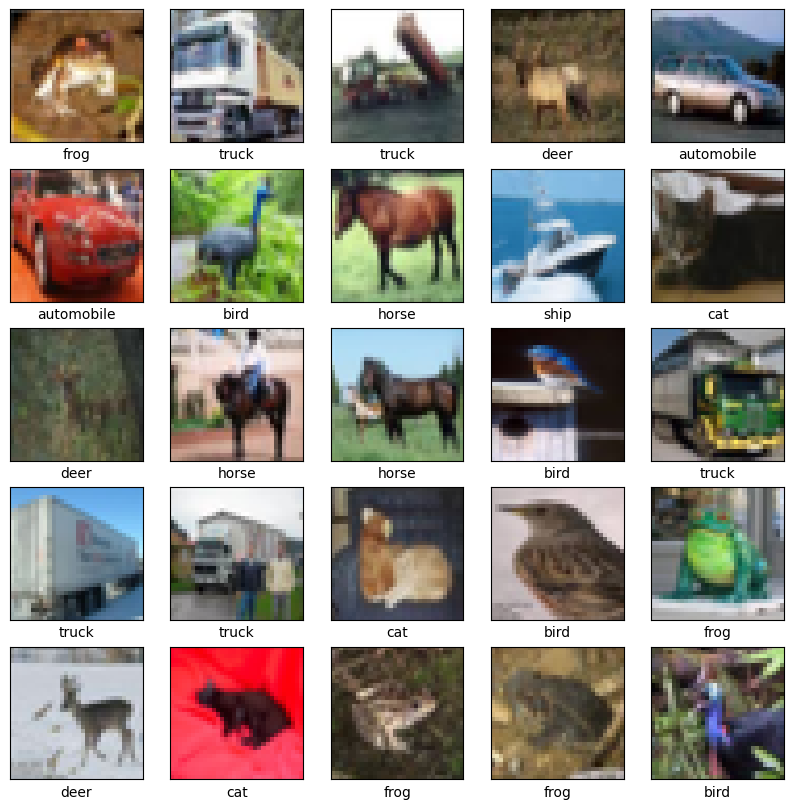

In [8]:
class_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
]

plt.figure(figsize=(10, 10))
for i in range(25):
  plt.subplot(5, 5, i + 1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_images[i])
  plt.xlabel(class_names[train_labels[i][0]])
plt.show()

### Building Convolutional Neural Network (CNN)

In [9]:
# Build the conv model
conv_model = keras.Sequential(
    [
        keras.layers.Conv2D(32, (3, 3), input_shape=(32, 32, 3), padding='same'),
        keras.layers.ReLU(name='relu1'),
        keras.layers.MaxPooling2D((2, 2)),

        keras.layers.Conv2D(64, (3, 3), padding='same'),
        keras.layers.ReLU(name='relu2'),
        keras.layers.MaxPooling2D((2, 2)),

        keras.layers.Conv2D(64, (3, 3), padding='same'),
        keras.layers.ReLU(name='relu3'),

        keras.layers.Flatten(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(10),
    ]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
# Compile the model with necessary loss function and optimizer
conv_model.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [11]:
# Train the Model
conv_hist = conv_model.fit(train_ds, epochs=30, validation_data=test_ds)

Epoch 1/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 22s 101ms/step - accuracy: 0.2883 - loss: 1.9254 - val_accuracy: 0.5089 - val_loss: 1.3890
Epoch 2/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 19s 96ms/step - accuracy: 0.5224 - loss: 1.3301 - val_accuracy: 0.5766 - val_loss: 1.1920
Epoch 3/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 19s 97ms/step - accuracy: 0.5982 - loss: 1.1362 - val_accuracy: 0.6221 - val_loss: 1.0699
Epoch 4/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 19s 95ms/step - accuracy: 0.6430 - loss: 1.0125 - val_accuracy: 0.6275 - val_loss: 1.0707
Epoch 5/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 19s 96ms/step - accuracy: 0.6744 - loss: 0.9317 - val_accuracy: 0.6680 - val_loss: 0.9599
Epoch 6/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 19s 95ms/step - accuracy: 0.6989 - loss: 0.8638 - val_accuracy: 0.6763 - val_loss: 0.9358
Epoch 7/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 19s 96ms/step - accuracy: 0.7208 - loss: 0.8068 - val_accuracy: 0.6926 - val_loss: 0.8961
Epoch 8/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 96ms/step - accuracy: 0.7347 - loss: 0.7640 -

### Involutional Neural Network

In [27]:
# Build the involution model
inputs = keras.Input(shape=(32, 32, 3))

x, _ = Involution(
    channel=3, group_number=1, kernel_size=3, stride=1, reduction_ratio=2, name="inv_1"
)(inputs)
x = keras.layers.ReLU()(x)
x = keras.layers.MaxPooling2D((2, 2))(x)

x, _ = Involution(
    channel=3, group_number=1, kernel_size=3, stride=1, reduction_ratio=2, name="inv_2"
)(x)
x = keras.layers.ReLU()(x)
x = keras.layers.MaxPooling2D((2, 2))(x)

x, _ = Involution(
    channel=3, group_number=1, kernel_size=3, stride=1, reduction_ratio=2, name="inv_3"
)(x)
x = keras.layers.ReLU()(x)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, activation="relu")(x)

outputs = keras.layers.Dense(10)(x)

inv_model = keras.Model(inputs=[inputs], outputs=[outputs], name="inv_model")

In [28]:
# Compile the mode with the necessary loss function and optimizer.
inv_model.compile(
    optimizer="adam",
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [29]:
# train the model
inv_hist = inv_model.fit(train_ds, epochs=20, validation_data=test_ds)

Epoch 1/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 18s 76ms/step - accuracy: 0.1625 - loss: 2.2241 - val_accuracy: 0.2774 - val_loss: 2.0594
Epoch 2/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.3319 - loss: 1.8598 - val_accuracy: 0.3704 - val_loss: 1.7730
Epoch 3/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.3720 - loss: 1.7548 - val_accuracy: 0.3880 - val_loss: 1.7199
Epoch 4/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.3902 - loss: 1.7036 - val_accuracy: 0.4004 - val_loss: 1.6799
Epoch 5/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.4069 - loss: 1.6674 - val_accuracy: 0.4084 - val_loss: 1.6529
Epoch 6/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.4164 - loss: 1.6329 - val_accuracy: 0.4182 - val_loss: 1.6294
Epoch 7/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.4266 - loss: 1.6082 - val_accuracy: 0.4235 - val_loss: 1.6098
Epoch 8/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.4299 - loss: 1.5898 - 

## Comparisons

### Parameters

In [33]:
conv_model.summary()

inv_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ relu1 (ReLU)                         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ relu2 (ReLU)                         │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 8, 8, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ relu3 (ReLU)                         │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         262,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 957,536 (3.65 MB)

 Trainable params: 319,178 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 638,358 (2.44 MB)

Model: "inv_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inv_1 (Involution)                   │ [(None, 32, 32, 3), (None,  │              26 │
│                                      │ 32, 32, 9, 1, 1)]           │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_16 (ReLU)                      │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 16, 16, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inv_2 (Involution)                   │ [(None, 16, 16, 3), (None,  │              26 │
│                                      │ 16, 16, 9, 1, 1)]           │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_18 (ReLU)                      │ (None, 16, 16, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 8, 8, 3)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inv_3 (Involution)                   │ [(None, 8, 8, 3), (None, 8, │              26 │
│                                      │ 8, 9, 1, 1)]                │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_20 (ReLU)                      │ (None, 8, 8, 3)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 192)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,230 (153.25 KB)

 Trainable params: 13,074 (51.07 KB)

 Non-trainable params: 6 (24.00 B)

 Optimizer params: 26,150 (102.15 KB)

> The parameters in a CNN `957,536` is much larger than that of an INN (Involutional Neural Network) `39,230`.

### Loss and Accuracy Plots

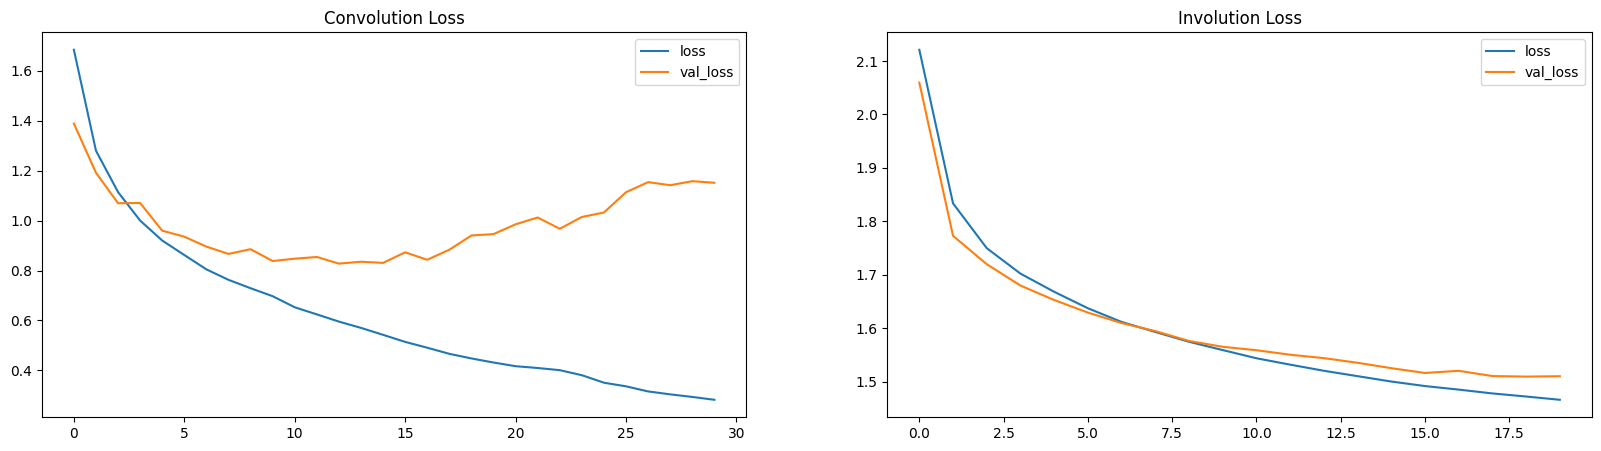

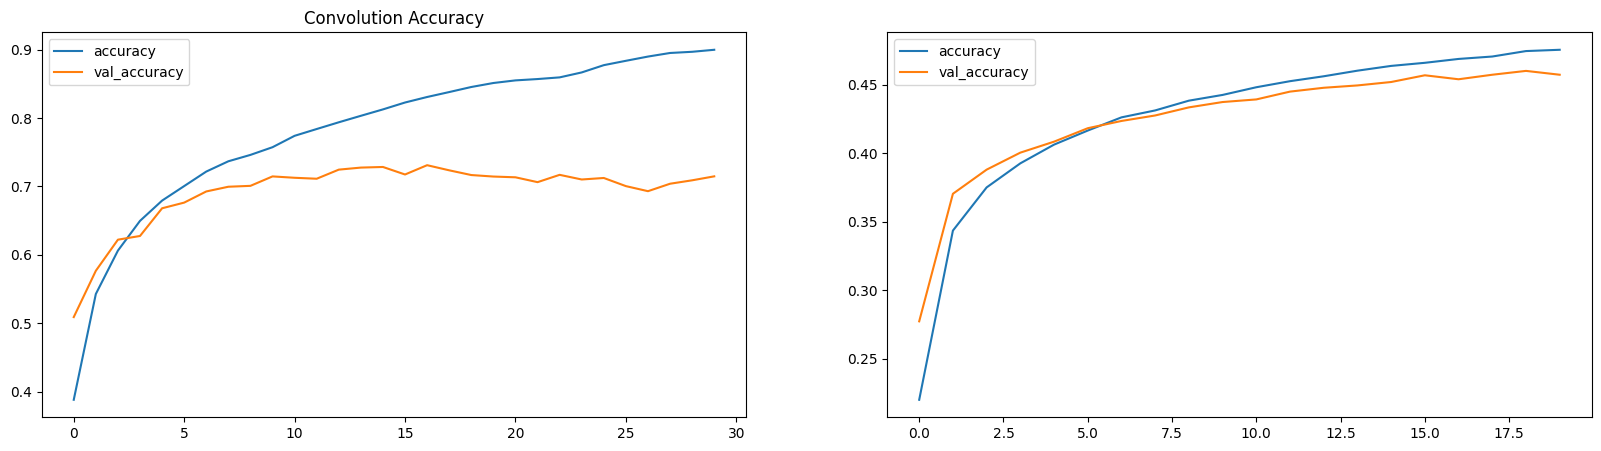

In [31]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.title('Convolution Loss')
plt.plot(conv_hist.history['loss'], label='loss')
plt.plot(conv_hist.history['val_loss'], label='val_loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Involution Loss')
plt.plot(inv_hist.history['loss'], label='loss')
plt.plot(inv_hist.history['val_loss'], label='val_loss')
plt.legend()

plt.show()

plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.title('Convolution Accuracy')
plt.plot(conv_hist.history['accuracy'], label='accuracy')
plt.plot(conv_hist.history['val_accuracy'], label='val_accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(inv_hist.history['accuracy'], label='accuracy')
plt.plot(inv_hist.history['val_accuracy'], label='val_accuracy')
plt.legend()

plt.show()

> Loss and Accuracy plots demonstrate that INNs are slow learners (with lower parameters).

### Visualizing Involution Kernels

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


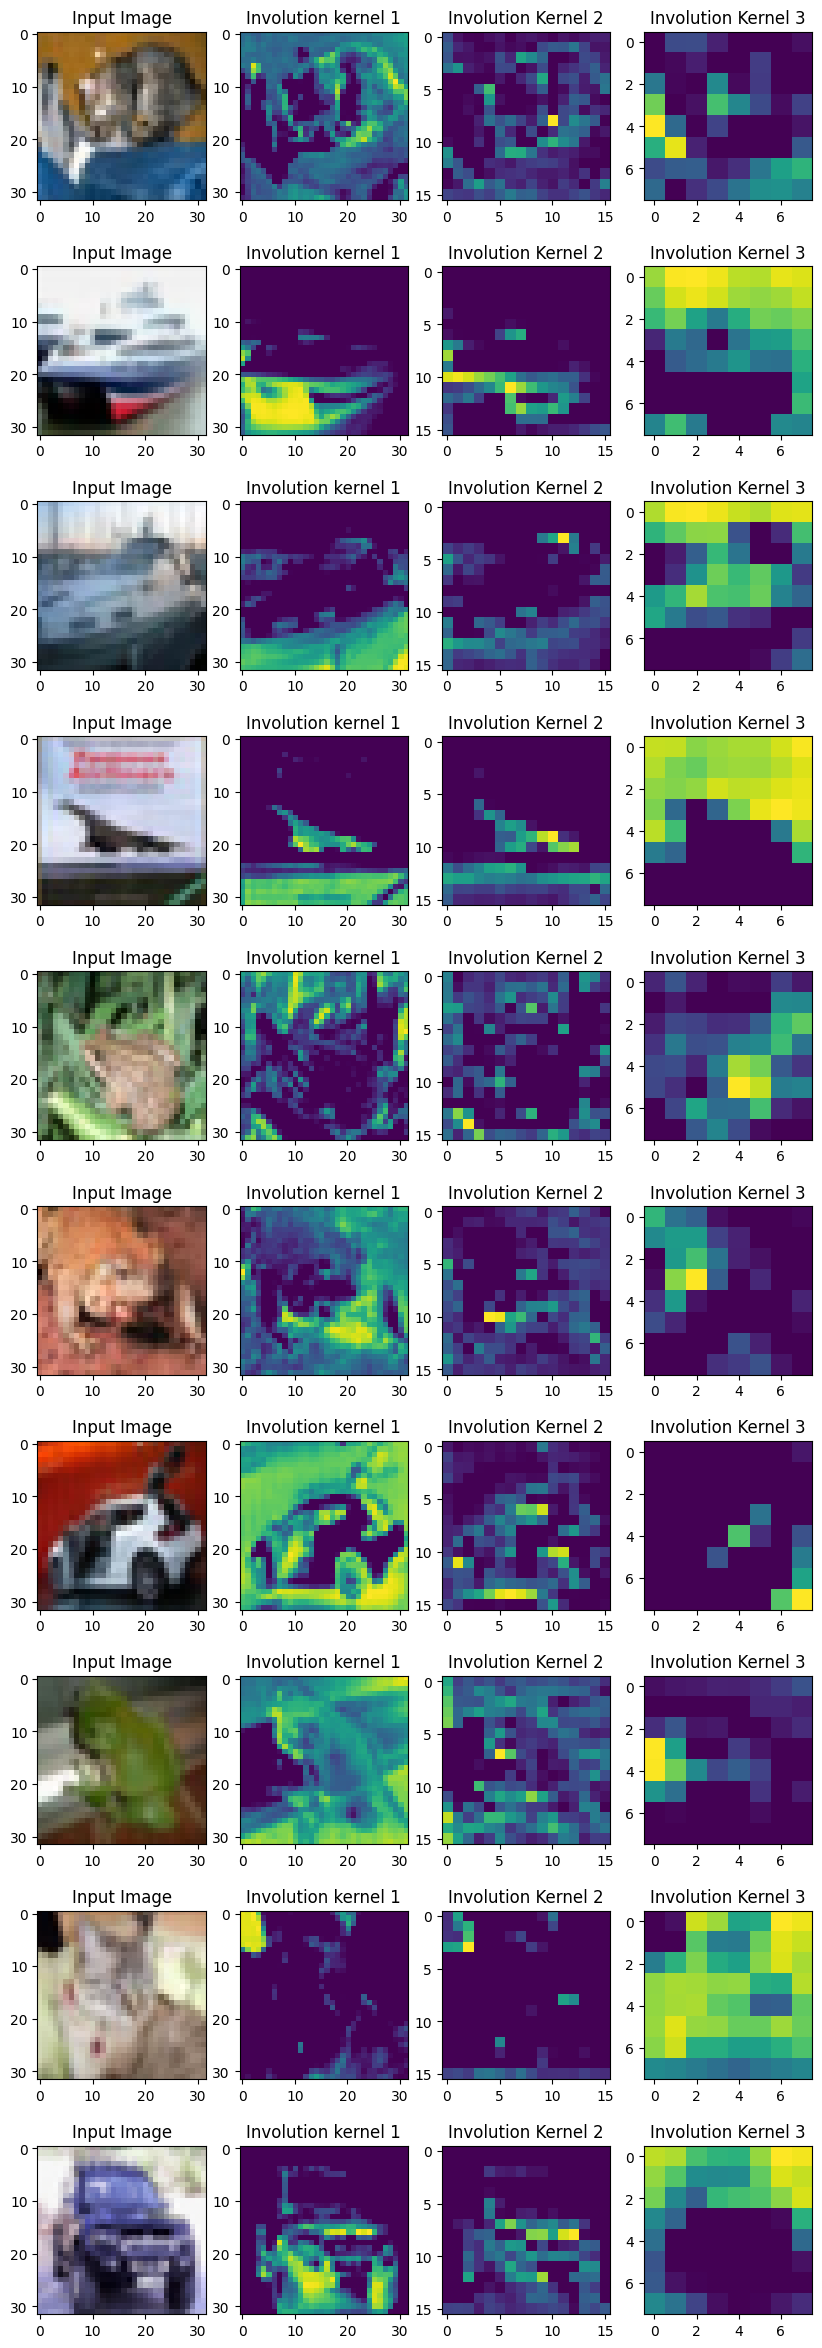

In [32]:
layer_names = ["inv_1", "inv_2", "inv_3"]
outputs = [inv_model.get_layer(name).output[1] for name in layer_names]
vis_model = keras.Model(inv_model.input, outputs)

fig, axes = plt.subplots(nrows=10, ncols=4, figsize=(10, 30))

for ax, test_image in zip(axes, test_images[:10]):
    (inv1_kernel, inv2_kernel, inv3_kernel) = vis_model.predict(test_image[None, ...])
    inv1_kernel = tf.reduce_sum(inv1_kernel, axis=[-1, -2, -3])
    inv2_kernel = tf.reduce_sum(inv2_kernel, axis=[-1, -2, -3])
    inv3_kernel = tf.reduce_sum(inv3_kernel, axis=[-1, -2, -3])

    ax[0].imshow(keras.utils.array_to_img(test_image))
    ax[0].set_title("Input Image")

    ax[1].imshow(keras.utils.array_to_img(inv1_kernel[0, ..., None]))
    ax[1].set_title("Involution Kernel 1")

    ax[2].imshow(keras.utils.array_to_img(inv2_kernel[0, ..., None]))
    ax[2].set_title("Involution Kernel 2")

    ax[3].imshow(keras.utils.array_to_img(inv3_kernel[0, ..., None]))
    ax[3].set_title("Involution Kernel 3")